In [1]:
from Classicality_Algorithm import *

## One main function `quickrun_poly` to run polygonal scenarios at (nsides,radius)=(n,r)

In [2]:
def quickrun_poly(n, digits, r=1, second_step_version=1, normalize_distances=True, round_distances=False, verbose=1):
    A = Algorithm(EPS=np.float_power(10,-digits))
    A.Rhos = A.generate_polygonal_rhos_in_xy_plane(n, r=r)
    
    A.Epsilons = A.Rhos.copy()
    
    A.run_algorithm(second_step_version=second_step_version, normalize_distances=normalize_distances, round_distances=round_distances, verbose=verbose)
    
    A.n = n
    return A

----

In [3]:
n=6;r=1
A = quickrun_poly(n=n, digits=14, r=r, verbose=2)
A

3 vectors were discarded during a Gram_Schmidt(QR) process.
3 vectors were discarded during a Gram_Schmidt(QR) process.
A 3-dimensional polyhedron in QQ^3 defined as the convex hull of 1 point, 6 rays
A 3-dimensional polyhedron in QQ^3 defined as the convex hull of 1 point, 6 rays
A 9-dimensional polyhedron in QQ^9 defined as the convex hull of 1 point, 36 rays
Number of inequalities: 552.
Result of classicality test: False.
Distance to classicality: 0.1825741858350521336483714694. (Minimal constraint value: -0.1825741858350521336483714694.)


### Old code, which searched *numerically* for intersection radius, when *no rotation of inner-polygon was allowed*:

In [5]:
def test_inner_poly_inside_outer_poly(outer_poly_n, outer_poly_r, 
                                      inner_poly_n, inner_poly_r,
                                      return_signed_distance=False):



    inner_poly_Vrep = [ [inner_poly_r*np.cos(2*k*np.pi/inner_poly_n), inner_poly_r*np.sin(2*k*np.pi/inner_poly_n)]
                        for k in range(inner_poly_n)]


    outer_poly_unitr_Vrep_complex = [outer_poly_r*np.exp( 1j * 2*k*np.pi/outer_poly_n)
                               for k in range(outer_poly_n)]
    outer_semi_angle = np.pi/outer_poly_n
    outer_r_inscribed_circle = outer_poly_r * np.cos(outer_semi_angle)
    outer_unitr_rotated_complexes = [ np.exp( 1j * outer_semi_angle )*z for z in outer_poly_unitr_Vrep_complex ]
    outer_poly_Hrep = [ [w.real, w.imag, -outer_r_inscribed_circle] for w in outer_unitr_rotated_complexes ]


    def point_signed_distance_to_poly(point, poly_Hrep):
        dists = [ point[0]*ineq[0] + point[1]*ineq[1] + 1*ineq[2]   for ineq in poly_Hrep]  
        return max(dists)



    if return_signed_distance:
        return max([ point_signed_distance_to_poly(inner_point, outer_poly_Hrep)
                                      for inner_point in inner_poly_Vrep ])

    else:
        inner_poly_is_inside_outer_poly = all(
                                    [ point_signed_distance_to_poly(inner_point, outer_poly_Hrep) <= 0
                                      for inner_point in inner_poly_Vrep ]
                                             )
        return inner_poly_is_inside_outer_poly



In [6]:
outer_poly_n = 4
outer_poly_r = 1.0
inner_poly_n = 5
inner_poly_r = .71593

test_inner_poly_inside_outer_poly(outer_poly_n, outer_poly_r, inner_poly_n, inner_poly_r, return_signed_distance=True)

8.93249572941901e-06

In [7]:
n_list = [3,4,5,6]
outs = {n: {} for n in n_list}

In [8]:
classicality_radiuses = {4: 1.0,  5: 0.8740320488975659,  6: 0.8164965809274178}

def polygon_n_r_contained_in_classical_polygon_nminus1_distance(r,
                                                                n):
    
    outer_poly_n = n-1
    outer_poly_r = classicality_radiuses[ outer_poly_n ]
    
    inner_poly_n = n
    inner_poly_r = r
    
    return test_inner_poly_inside_outer_poly(outer_poly_n, outer_poly_r, inner_poly_n, inner_poly_r, return_signed_distance=True)


n_list = [4,5,6]

outs = {n: {} for n in n_list}

#### find classicality crossing radius
for n in n_list:
    if n>=5:    
        search_range_min = 0.01
        search_range_max = 0.99

        root = find_root_brentq(polygon_n_r_contained_in_classical_polygon_nminus1_distance, search_range_min, search_range_max,
                               args=(n))


        outs[n]['root'] = root
        print(f"n={n}: geometrical maximal r such that 2d ngon ({n},r) contained in largest classicality ngon ({n-1}, r_class({n-1})={classicality_radiuses[ n-1 ]}):\nr = {root}.\n")
    else:
        outs[n]['root'] = False



n=5: geometrical maximal r such that 2d ngon (5,r) contained in largest classicality ngon (4, r_class(4)=1.0):
r = 0.7159209561595877.

n=6: geometrical maximal r such that 2d ngon (6,r) contained in largest classicality ngon (5, r_class(5)=0.8740320488975659):
r = 0.8090169943749475.


- for `n=5`: on mathematica, we graphically find the same value.

- for `n=6`: on mathematica, we graphically find a value that's around 0.72...  --> code above is to be debugged...

----

### New code, which gives *analytically* intersection radius, when *rotation of inner-polygon is allowed*:

In [9]:
def radius_of_inscribed_circle_in_poly(n,r):
    """Radius of (maximal/tangent) inscribed circle to regular `n`-polygon of radius `r`."""
    semi_angle = np.pi/n
    r_inscribed_circle = r * np.cos(semi_angle)
    return r_inscribed_circle

n_list = [4,5,6,7,8]
classicality_radiuses = {4: 1.0,  5: 0.8740320488975659,  6: 0.8164965809274178,  7: 0.7848293169471976,  8: 0.7653668647301741}

# Since rotation of inner polygon is allowed, if we choose it to have
# radius=radius_of_inscribed_circle_in_poly(n_outer, r_outer), it can always then theoretically be rotated
# such that one of its vertex touches an edge of the outer_poly.
# (this happens iif the ray going from the origin to this rotated vertex intersects that edge in its middle.)
max_r_contained_in_nminus1_classical = {n: radius_of_inscribed_circle_in_poly(n-1, classicality_radiuses[n-1]) 
                                        for n in [5,6,7,8,9]}

print(*max_r_contained_in_nminus1_classical.items(), sep='\n')
print('-'*24)
print('sqrt(2)/2 =\n'+' '*4 + str(np.sqrt(2)/2))

(5, 0.7071067811865476)
(6, 0.7071067811864858)
(7, 0.7071067811862807)
(8, 0.7071067811865456)
(9, 0.7071067811865425)
------------------------
sqrt(2)/2 =
    0.7071067811865476


- Somehow the `classicality_radiuses` are such that these above geometrical containement values are always sqrt(2)/2 ...

- --> Assuming that's true, inverting the equation

$$\mathrm{radius\_of\_inscribed\_circle\_in\_poly}(n,r) = \frac{\sqrt{2}}{2}$$

gives an analytical formula for

$$r_{\mathrm{class}}(n)$$

(yellow curve on plot below). 

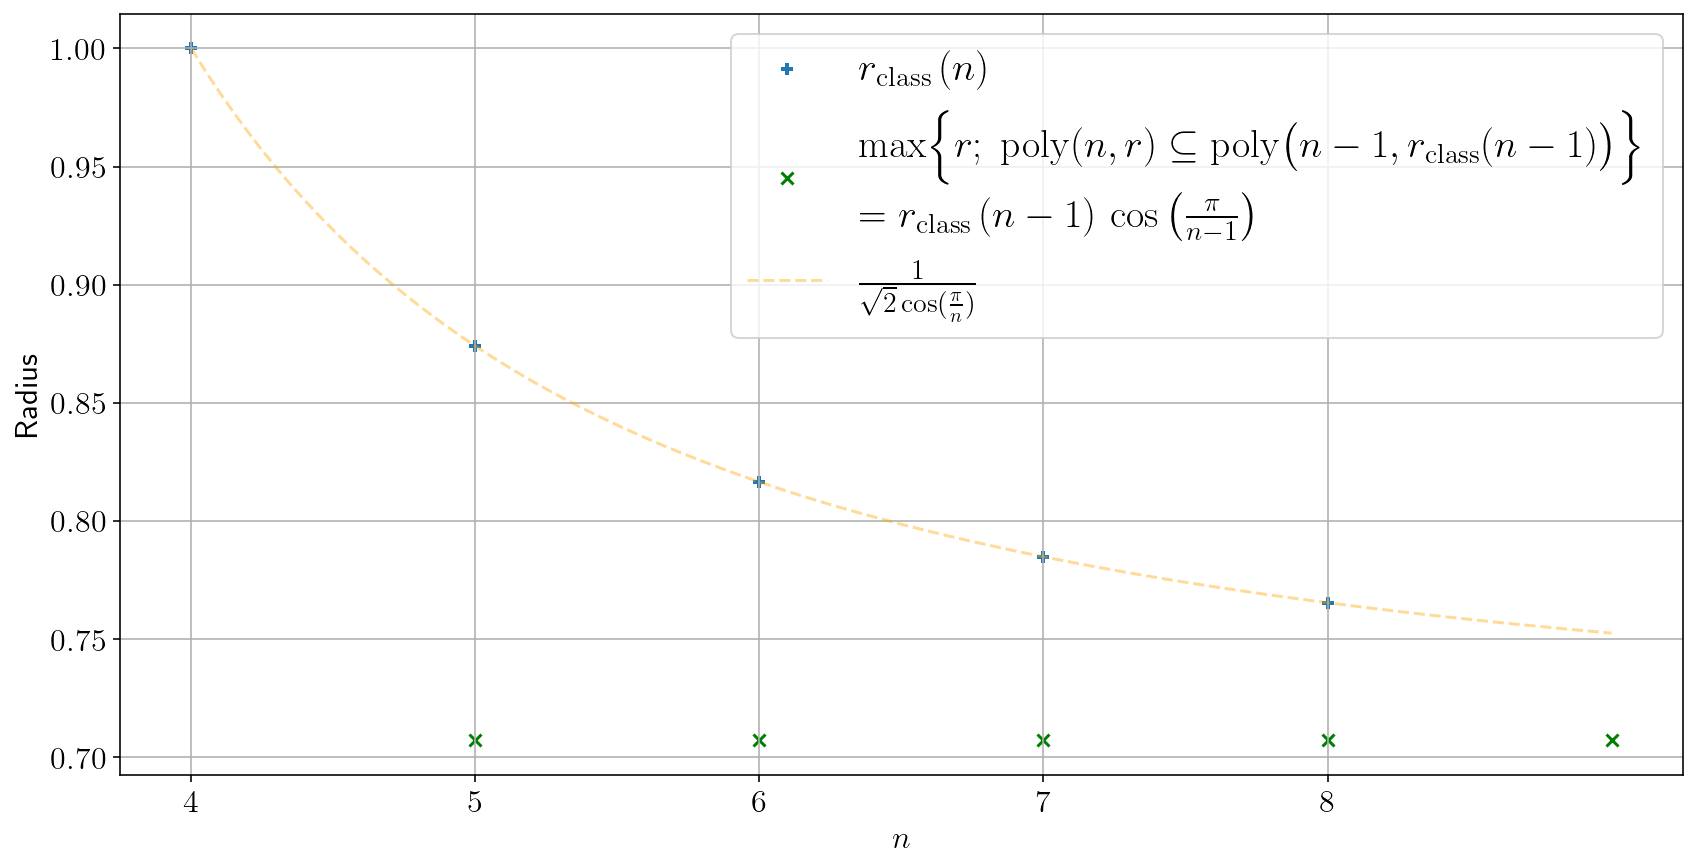

In [10]:
%config InlineBackend.figure_format = 'retina'

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

mpl.rcParams.update({'font.size': 16})


n_list = np.array([4,5,6,7,8])

plt.figure(figsize=(14,7))

plt.scatter(classicality_radiuses.keys(),
            classicality_radiuses.values(),
            label=r'$r_{\mathrm{class}}\left(n\right)$',
            marker='+', linewidths=2)

plt.scatter(max_r_contained_in_nminus1_classical.keys(),
            max_r_contained_in_nminus1_classical.values(),
            label=r'$ \max\Bigl\{r;\; \mathrm{poly}(n,r) \subseteq \mathrm{poly}\bigl(n-1,r_{\mathrm{class}}(n-1)\bigr) \Bigr\} $'
           '\n'  # Newline: the backslash is interpreted as usual
           r'$=r_{\mathrm{class}}\left(n-1\right)\, \cos\left(\frac{\pi}{n-1}\right)$',
            marker='x', color='green')



def r_class_possible_analytical_formula(n):
    return 1/( np.sqrt(2) * np.cos(np.pi/n) )



n_continuous = np.linspace(4,9,num=100)
plt.plot(   n_continuous,
            r_class_possible_analytical_formula(n_continuous),
            label=r'$\frac{1}{\sqrt{2} \cos(\frac{\pi}{n})}$',
            ls='--', color='orange', alpha=0.4)

plt.grid()

plt.xlabel('$n$')
plt.xticks(n_list)

plt.ylabel('Radius')

#plt.legend(prop={'size': 20})

#reorder legend which had non correct order.
plt.legend(*(
    [ x[i] for i in [1,2,0] ]
    for x in plt.gca().get_legend_handles_labels()
), prop={'size': 20})

plt.show()

Note: To be more explicit, the formula in the legend for the green points should really be:

$$ \max\Bigl\{r;\; \exists \phi_{\mathrm{offset}} ,\, \mathrm{poly}(n,r,\phi_{\mathrm{offset}}) \subseteq \mathrm{poly}\bigl(n-1,r_{\mathrm{class}}(n-1),\phi=0\bigr) \Bigr\} $$